# SARIMA

The goal of this notebook is fitting a SARIMA model,
$$ \Phi_P(B^P) \phi_p(B^s) \nabla_s^D \nabla^d X_t = \Theta_Q(B^s) \theta_p(B) Y_t,$$
where

$$ \begin{array}{rcl}
\Phi_P(B) &=& 1 - \Phi_1 B - \Phi_2 B^2 - \dotsb - \Phi_P B^P, \\
\phi_p(B) &=& 1 - \phi_1 B - \phi_2 B^2 - \dotsb - \phi_p B^p, \\
\Theta_Q(B) &=& 1 + \Theta_1 B + \Theta_2 B^2 + \dotsb + \Theta_Q B^Q, \\
\theta_q(B) &=& 1 + \theta_1 B + \theta_2 B^2 + \dotsb + \theta_q B^q, \\
\nabla &=& 1 - B, \\
\nabla_s &=& 1 - B^s.
\end{array}$$

### Index
* [Box-Cox transformation](#boxcox) 
* [Parameter estimation](#param_est)
    * [Determinig $d$ and $D$](#ds)
    * [Determining $p$, $q$, $P$ and $Q$](#pq)
* [Model prososals](#model_prop)
* [Predictions](#predictions)

**Packages**

In [1]:
import os
import numpy as np
import pandas as pd
import datetime

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import pmdarima as pm

import os
from pathlib import Path
project_path = Path(os.getcwd()).parent
import pickle
import joblib  

In [2]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

In [3]:
def invboxcox(y,ld):
    if ld == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(ld*y+1)/ld))

**Load data**

In [4]:
train = pd.read_parquet("../data/03_train-test/summed_data_train.parquet")
test = pd.read_parquet("../data/03_train-test/summed_data_test.parquet")

Text(0.5, 1.0, 'Daily electricity demand')

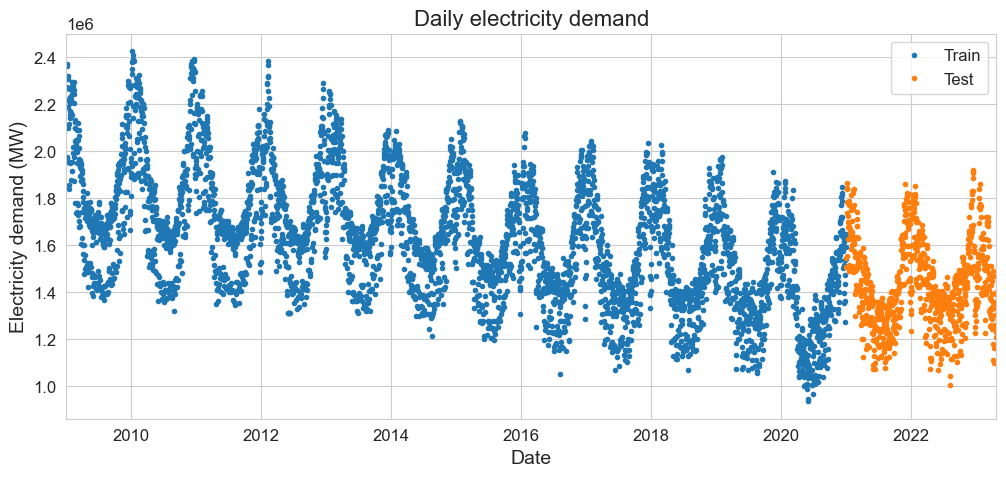

In [5]:
train['tsd'].plot(style=".", figsize=(12, 5), label='Train')
test['tsd'].plot(style=".", label='Test')
plt.legend()
plt.ylabel("Electricity demand (MW)")
plt.xlabel('Date')
plt.title("Daily electricity demand")

<a id='boxcox'></a>
## Box-Cox transformation

In [6]:
import scipy.stats as sc 

X = sc.boxcox(train['tsd'])
l = X[1]
print('lambda = ', l)

lambda =  0.4040241192023432


In [7]:
X = pd.DataFrame(X[0], index = train.index, columns = ['ts'])
X

,ts
settlement_date,
2009-01-01,840.123665
2009-01-02,862.693760
2009-01-03,858.723129
2009-01-04,861.677378
2009-01-05,913.100319
...,...
2020-12-27,741.970997
2020-12-28,780.168837
2020-12-29,790.615244


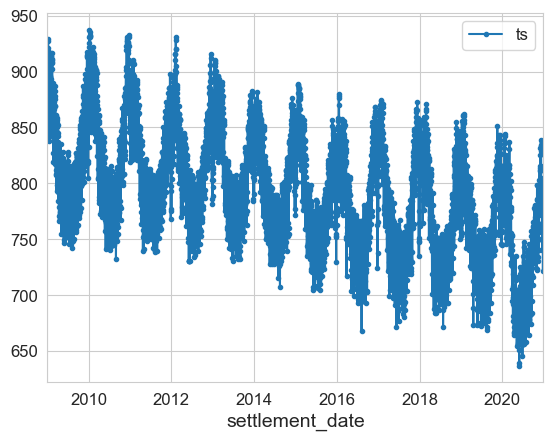

In [8]:
X.plot(marker='.')

<a id='param_est'></a>
## Parameter estimation

<a id='ds'></a>
### Determining $d$ and $D$

In [9]:
def dftest(timeseries, window_size):
    dftest = sm.stattools.adfuller(timeseries)
    
    dfoutput = pd.Series(
        dftest[0:4],
        index=["Test Statistic", "p-value", "Lags Used", "Observations Used"])
    
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    # Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    # Plot rolling statistics:
    plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.grid(True)
    plt.show(block=False)


def autocorr_plots(train, lags=None):
    plt.figure(figsize=(20, 10))
    layout = (3, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))

    raw.plot(train)
    sm.graphics.plot_acf(train, lags=lags, ax=acf, zero=False, auto_ylims=True)
    sm.graphics.plot_pacf(train, lags=lags, ax=pacf, zero=False, auto_ylims=True, method="ywm")
    sns.despine()
    plt.tight_layout()

We start checking the results of the _Aumented Dickey-Fuller test_, where the null hypothesis is

$$H_0: X_t \text{ is non-stacionary.} $$

Test Statistic            -3.979933
p-value                    0.001519
Lags Used                 28.000000
Observations Used       4354.000000
Critical Value (1%)       -3.431853
Critical Value (5%)       -2.862204
Critical Value (10%)      -2.567123
dtype: float64


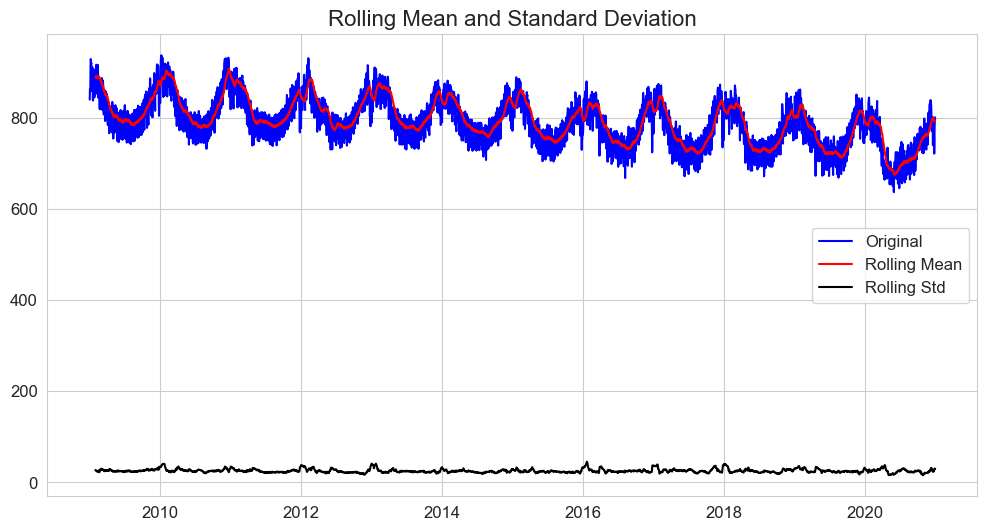

In [10]:
dftest(X, 30)

According to the test statistics and the p-value, the time series is stationary. Nevertheless, the plot show seasonality and a trend, so the time series is **not stationary**.

Now, we will look at the 1-day difference train. We define $$W_t = \nabla X_t = X_t - X_{t-1}.$$ 

In [11]:
W = (X - X.shift(1)).dropna()

Test Statistic         -1.343886e+01
p-value                 3.880838e-25
Lags Used               2.700000e+01
Observations Used       4.354000e+03
Critical Value (1%)    -3.431853e+00
Critical Value (5%)    -2.862204e+00
Critical Value (10%)   -2.567123e+00
dtype: float64


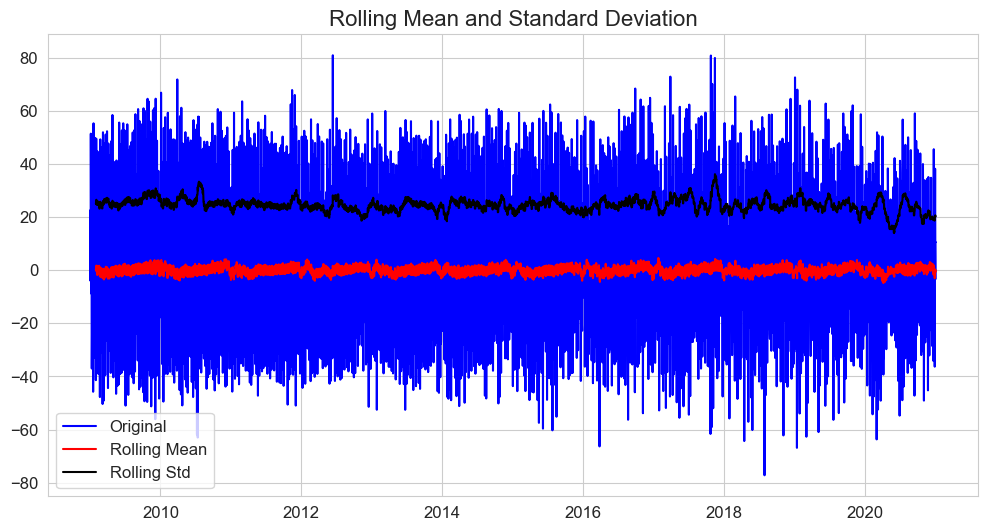

In [12]:
dftest(W, 30)

In this case, with the test we obtain that the series is stationary and if we look the plot, we see that we have removed the trend component. So we choose, $d=1$ for our model.

The next step is to determine $D$. We start studying the seasonality.

In [13]:
def seasonalplot(df, s, start_year):
    df = df.reset_index(drop=True)
    N = len(df)
    s = 364
    plt.figure(figsize=(15,4), dpi=100)
    for i in range(N//s):
        plt.plot(range(1,s+1), df.loc[s*i:(s*(i+1)-1)])

    plt.gca().set(title='Seasonal Plot', xlabel='Months', ylabel='Number of Passengers')
    plt.xticks(range(1,365,31), ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend(range(start_year, start_year+N+1), loc='center right', bbox_to_anchor=(1.1, 0.5))
    plt.show()

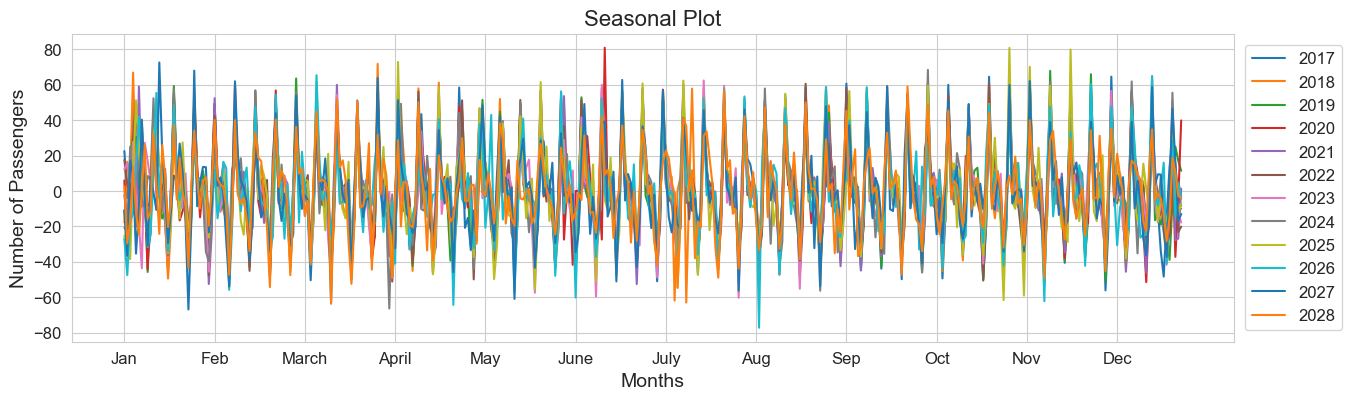

In [14]:
seasonalplot(W, s=365, start_year=2017)

We try apply the seasonal differece operator and define $$W^*_t = \nabla_{365} W_t = \nabla_{365}\nabla X_t.$$

In [15]:
W2 = (W - W.shift(365)).dropna()

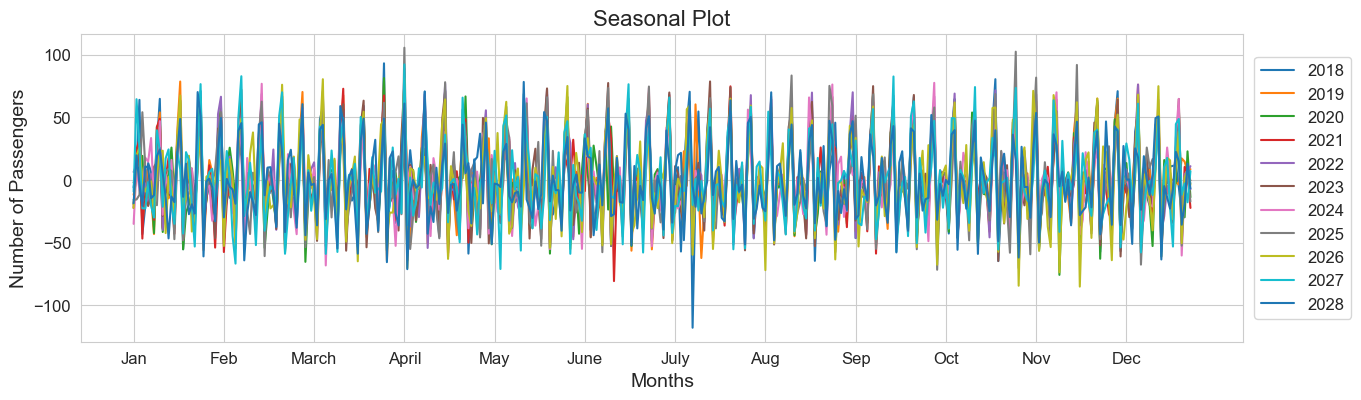

In [16]:
seasonalplot(W2, 365, start_year=2018)

We check if the seasonal component is stationary:

Test Statistic         -1.648044e+01
p-value                 2.239783e-29
Lags Used               2.700000e+01
Observations Used       3.989000e+03
Critical Value (1%)    -3.431990e+00
Critical Value (5%)    -2.862265e+00
Critical Value (10%)   -2.567156e+00
dtype: float64


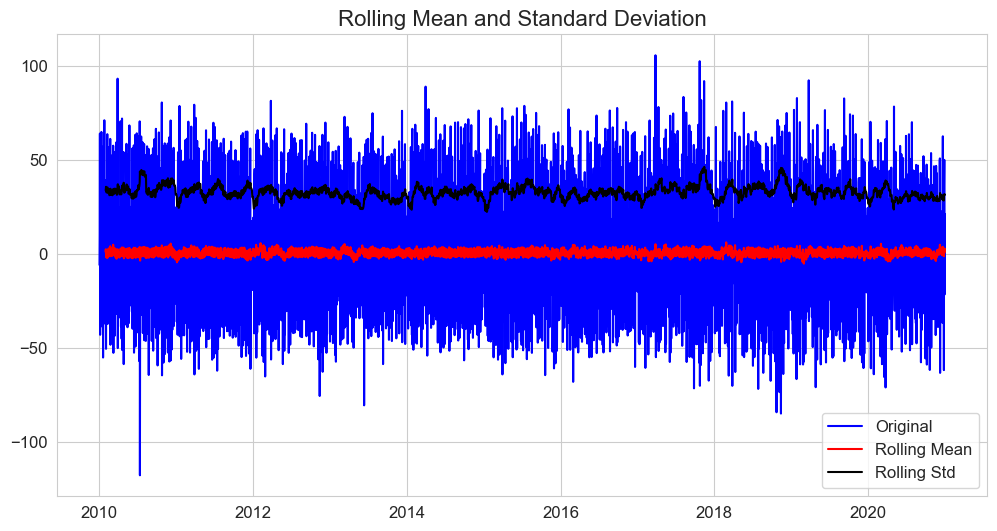

In [17]:
dftest(W2, 30)

We set the value $D=1$.

<a id='pq'></a>
### Determining $p$, $q$, $P$ and $Q$

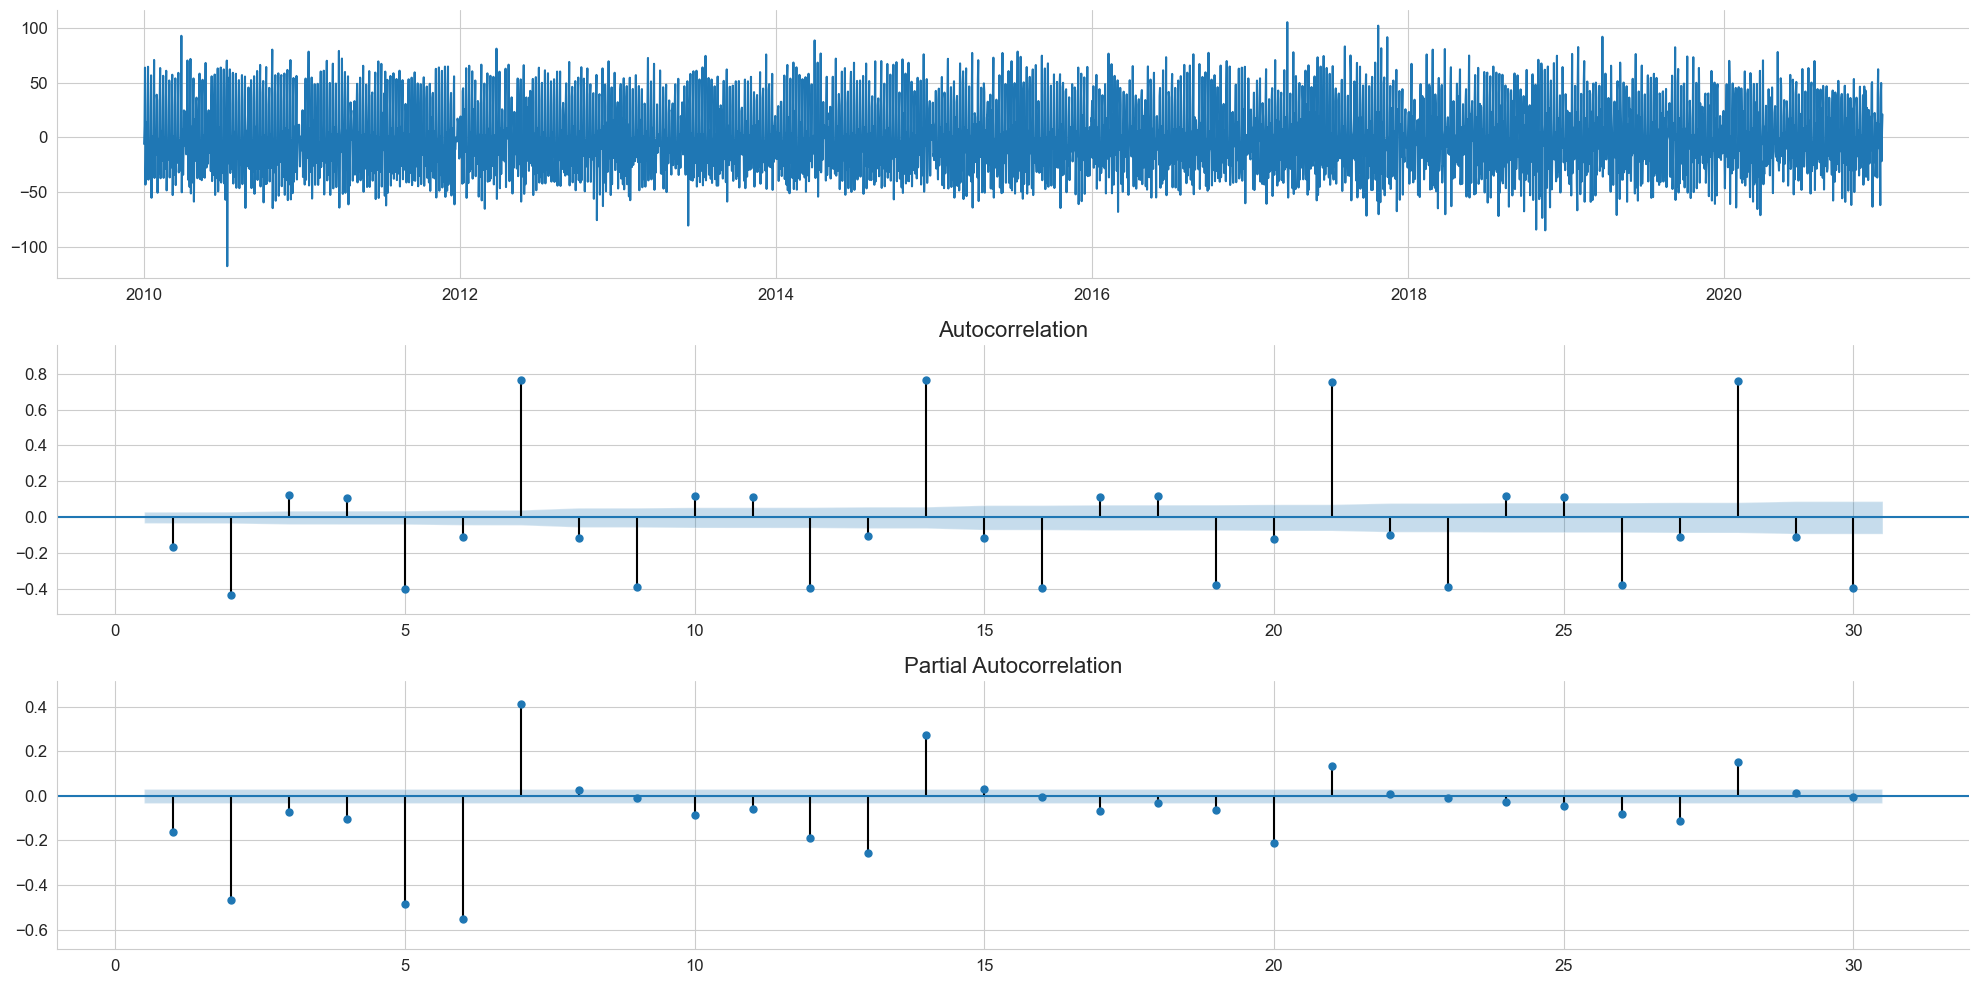

In [18]:
autocorr_plots(W2, lags=30)

<a id='model_prop'></a>
## Model prososals

**Model 1**

In [28]:
%%time
mod = sm.tsa.arima.ARIMA(X, order=(1, 1, 2), seasonal_order=(1, 1, 1, 365))
res = mod.fit(method='innovations_mle', low_memory=True, cov_type='none')

C:\Users\mpena\anaconda3\envs\py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mpena\anaconda3\envs\py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mpena\anaconda3\envs\py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mpena\anaconda3\envs\py37\lib\site-packages\statsmodels\tsa\arima\model.py:405: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  ' estimation by method "%s".' % method)


Wall time: 23min 50s


In [64]:
# save the model
joblib.dump(mod, project_path.joinpath('data/models/SARIMA.pkl'))

['C:\\Users\\mpena\\OneDrive\\Escritorio\\TFG\\CODIGO\\TFG\\data\\models\\SARIMA11.pkl']

In [19]:
SARIMA = joblib.load(project_path.joinpath('data/models/SARIMA.pkl'))

In [20]:
print(SARIMA.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                  ts   No. Observations:                 4383
Model:             ARIMA(1, 1, 2)x(1, 1, [1], 365)   Log Likelihood              -18114.463
Date:                             Tue, 04 Jul 2023   AIC                          36240.926
Time:                                     18:17:29   BIC                          36278.716
Sample:                                 01-01-2009   HQIC                         36254.319
                                      - 12-31-2020                                         
Covariance Type:                      Not computed                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0634        nan        nan        nan         nan         nan
ma.L1         -0.2977      

###### Diagnosis 

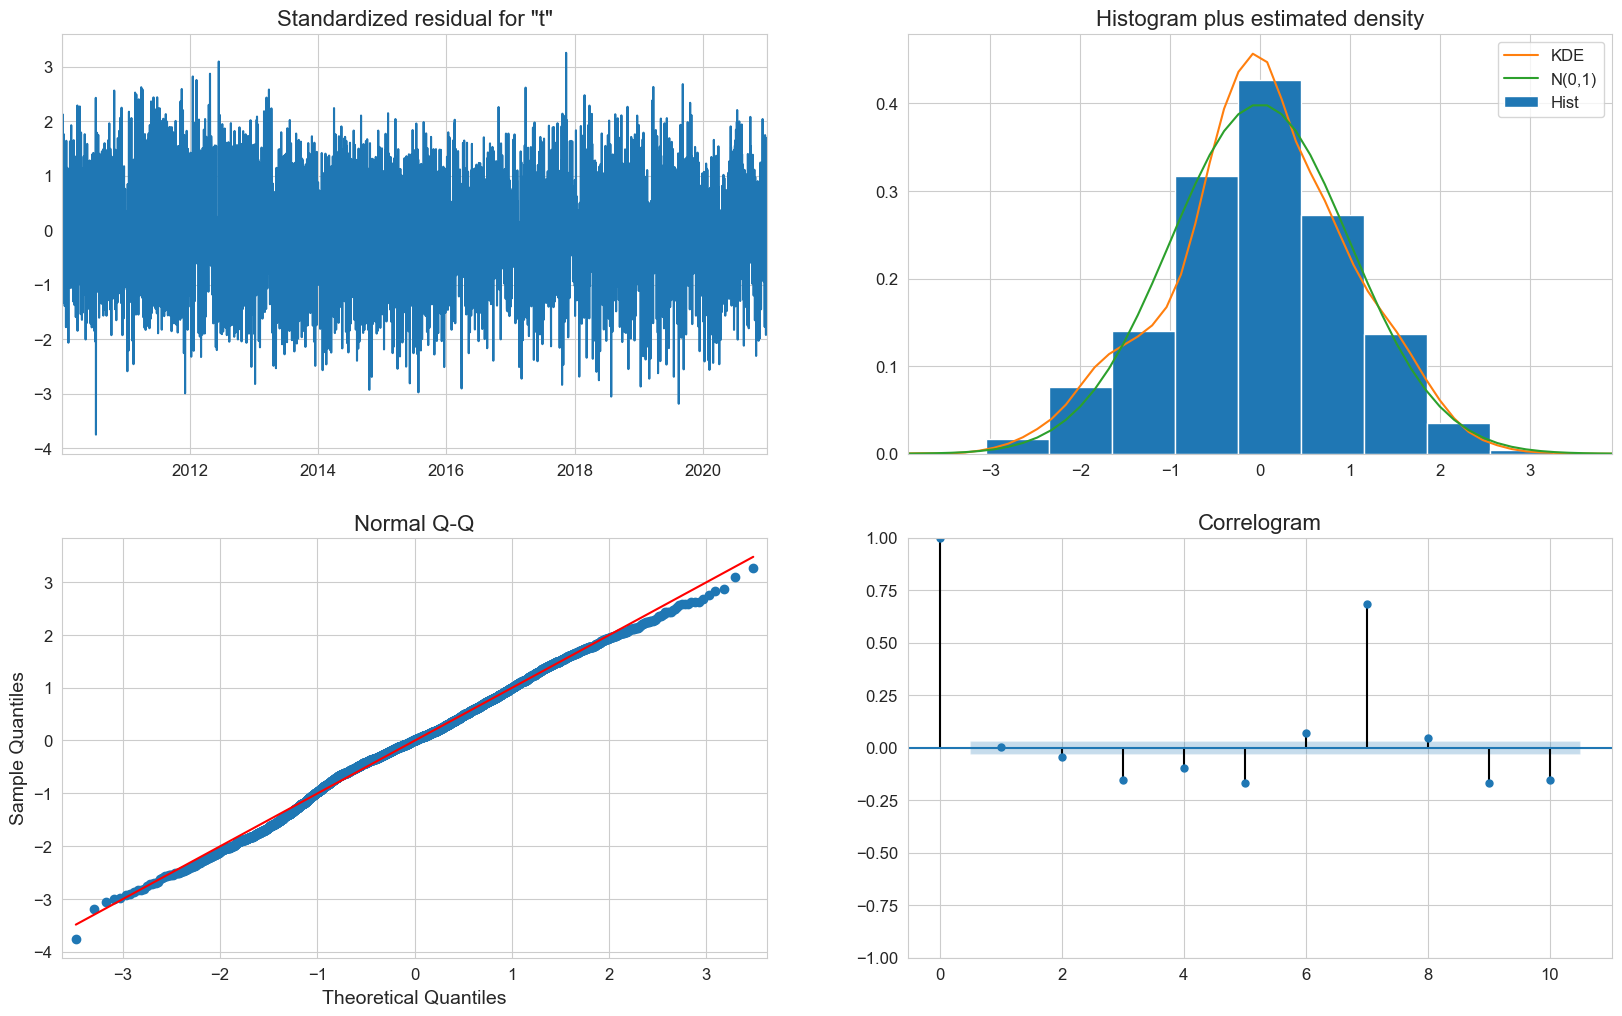

In [34]:
SARIMA.plot_diagnostics(figsize=(20, 12))
plt.show()

**Model 2**

The time computation is to high because the seasonal component is is to high.

In [22]:
# %%time
# mod2 = sm.tsa.arima.ARIMA(X, order=(3, 1, 2), seasonal_order=(3, 1, 3, 365))
# res2 = mod2.fit(method='innovations_mle', low_memory=True, cov_type='none')

<a id='predictions'></a>
## Predictions

In [24]:
fittedvalues1 = invboxcox(SARIMA.fittedvalues, l)
pred1 = invboxcox(SARIMA.predict(start=datetime.date(2021,1,1), end=datetime.date(2023,4,25)), l)

In [25]:
predict = SARIMA.get_prediction(start="01-01-2021", end=datetime.date(2023,4,25))

In [26]:
conf_int1 = predict.conf_int(alpha=0.05)
conf_int1 = invboxcox(conf_int1, l)

In [27]:
pred1

2021-01-01    1.630689e+06
2021-01-02    1.653382e+06
2021-01-03    1.647370e+06
2021-01-04    1.631580e+06
2021-01-05    1.645613e+06
                  ...     
2023-04-21    1.195287e+06
2023-04-22    1.191559e+06
2023-04-23    1.246010e+06
2023-04-24    1.256568e+06
2023-04-25    1.254251e+06
Freq: D, Name: predicted_mean, Length: 845, dtype: float64

In [28]:
fittedvalues1 = fittedvalues1.drop(['2009-01-01', '2010-01-01'], axis='index')

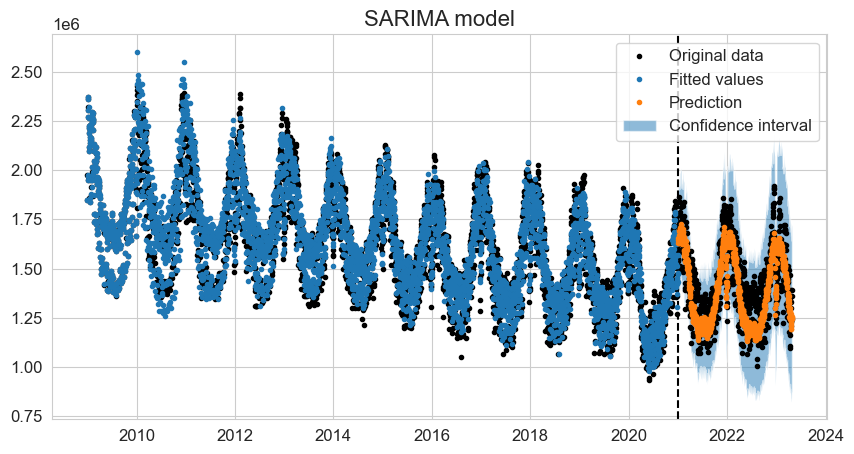

In [29]:
fig = plt.figure(figsize=(10,5))
plt.axvline(datetime.date(2021,1,1), color="black", ls="--")
plt.plot(train, '.', color='black', label='Original data')
plt.plot(test, '.',  color='black')
plt.plot(fittedvalues1,'.', label='Fitted values')
plt.plot(pred1, '.', label='Prediction')
plt.fill_between(
        conf_int1.index,
        conf_int1["lower ts"],
        conf_int1["upper ts"],
        alpha=0.5, label='Confidence interval'
    )
plt.legend(loc='upper right')
plt.title('SARIMA model')

plt.savefig("../graphs/SARIMA.png")

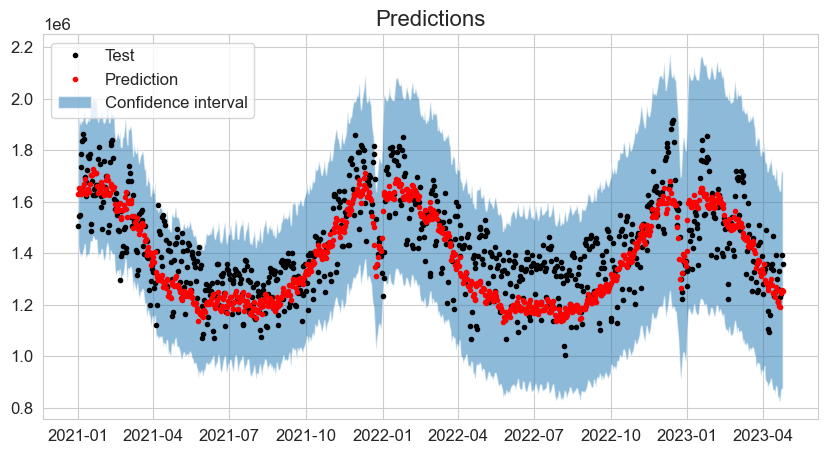

In [30]:
fig = plt.figure(figsize=(10,5))
plt.plot(test, '.',  color='black', label='Test')
plt.plot(pred1, '.', color='red', label='Prediction')
plt.fill_between(
        conf_int1.index,
        conf_int1["lower ts"],
        conf_int1["upper ts"],
        alpha=0.5, label='Confidence interval'
    )
plt.legend(loc='upper left')
plt.title('Predictions')
plt.savefig("../graphs/SARIMA_pred.png")

### Error

In [31]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [32]:
mape = mean_absolute_percentage_error(y_true=test, y_pred=pred1)
print(
    "Mean Absolute Percentage Error: %.2f"
    % mape
)

Mean Absolute Percentage Error: 14.31


In [33]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true=test, y_pred=pred1)

17610999854.718975

In [ ]:
17610999854